<a href="https://colab.research.google.com/github/franziskaschmidt1993/Analyse_Quartiersentwicklungsprojekte_Gesundheit/blob/master/200707_Berlin_Brandenburg_CapitalRegion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Topic: growth of the "Capital Region" Berlin-Brandenburg**



## Introduction

The German capital Berlin and it's surrounding state Brandenburg have always had a close connection in terms of economy, infrastructure, labour market, housing market and other supplies. As a consequence of the region's rich history and close relation, a merger of the two states was attempted in 1996. However, it was rejected in a referendum by the populations of the two states. Since then, the connections are still close, especially in terms of labour market and housing market. Many people live in Brandenburg and work in Berlin and vice versa. The region's coordination is regulated by the joint state planning of Berlin and Brandenburg (Gemeinsame Landesplanung Berlin Brandenburg).

One of the main concerns of this coordination office is the planning of the different areas with the help of the „Landesentwicklungsplan Hauptstadtregion Berlin-Brandenburg“ ([Regional Development Plan of the Capital Region Berlin-Brandenburg](https://gl.berlin-brandenburg.de/landesplanung/landesentwicklungsplaene/lep-hr/)) A big challenge for the plan is the fact that some areas are growing, others are shrinking. These disparities must be taken into account. 

Therefore, this visualization project seeks to compare the growth of the different parts of the Capital Region. The question is to be answered to what extent spatial location and growth or shrinkage have a connection.

 

# Data Sources and Data Cleaning

The Amt für Statistik Berlin-Brandenburg (joint statistical office of city state Berlin and area state Brandenburg) provides open data for different administrative levels on many core topics. They are mostly periodically issued (pdf or excel-files). Therefore, if one wants to look at a time series of data, one has to merge the annual data in excel. As the community ids and the administrative levels can differ from year to year, some data cleaning/wrangling is needed. Some knowledge on adminstrative levels in Berlin and Brandenburg is handy as well, to set the administrative levels (see xxx) right). (Links!)

The data sets I used for this dossier (processed and merged into one excel file):
*  [population status in Berlin and Brandenburg (states, districts, municipalitie, boroughs. Available 2005-2018)](https://www.statistik-berlin-brandenburg.de/grundlagen/Bev-stand.asp?Ptyp=50&Sageb=12015&creg=BBB&anzwer=6)



# Preparing the Data Frame

## Preparation and Uploading the DataSet containing demographic statistics

The prepared data sheet is uploaded in Google Colab and all important packages are imported

In [ ]:
#Get pandas
import pandas as pd
import numpy as np


# upload file
from google.colab import files
uploaded = files.upload()

Saving DataGrowthCapitalRegion.xlsx to DataGrowthCapitalRegion.xlsx


In [ ]:
#use Pandas XlsxWriter DataFrame output to read the excel file
import io
BerlinBrandenburg_growthdata = pd.read_excel(io.BytesIO(uploaded['DataGrowthCapitalRegion.xlsx']))
BerlinBrandenburg_growthdata

,community identification number,name,administrative division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018
0,11000000,Berlin,Bundesland,Berlin,Berlin,3416255,3431675,3442675,3460725,3326002,3375222,3421829,3469849,3520031,3574830,3613495,3644826
1,12,Brandenburg,Bundesland,Brandenburg,Brandenburg,2535737,2522493,2511525,2503273,2453180,2449511,2449193,2457872,2484826,2494648,2504040,2511917
2,12060000,Landkreis Barnim,Landkreis,Barnim,Brandenburg,176888,176904,176848,172572,173193,173754,174981,177411,179365,180864,182760,176821
3,12060005,Ahrensfelde,Gemeinde,Barnim,Brandenburg,13090,13114,13028,12727,12761,12769,12856,12954,13068,13307,13543,13006
4,12060012,Althüttendorf,amtsangehörige Gemeinde,Barnim,Brandenburg,785,756,749,690,805,768,675,614,564,585,579,719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,8,Neukölln,Bezirk,Berlin,Berlin,307400,308500,312900,312100,300000,307700,312200,315500,319800,322700,327300,324100
442,9,Treptow-Köpenick,Bezirk,Berlin,Berlin,238000,240500,242500,241200,239100,241900,243400,245800,248100,252600,256000,263200
443,10,Marzahn-Hellersdorf,Bezirk,Berlin,Berlin,250700,250200,249200,249300,244900,248000,250200,251800,254400,257200,260300,263100
444,11,Lichtenberg,Bezirk,Berlin,Berlin,260300,260100,261000,259800,253700,257500,261400,265100,268100,275200,280500,286100


As we can see, the data contains statistical information as well as basic information on the community identification number and administrative affiliations.

Germany has different territorial divisions (Federal States (Bundesland), districts (Landkreis), municipalities (Gemeinden or kreisfreie Stadt)). The state Brandenburg is structured in this way.Berlin however has the status of an independent "city state". It is subdivided into 12 boroughs (Bezirke), which are administratively not comparable with districts (Landkreise) in area states.

However, they are statistically relevant, as a single Bezirk has between 240.000 and 400.000 inhabitants. Therefore, there are used as a reference to the districts in Brandenburg.

## Importing the Geodata

To visualize the data, we will use a map in order to show spacial difference and similarities. 

OpenStreetMap is a collaborative and Open Source map, which can be used as a base for the map in this project as it contains not only geo-information, but also other data, tags etc.

I'm using geopandas (an Open Source project) to make use of geo-data in Python.

In [ ]:
#preparation (importing all packages needed for a visualization)
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt

# importing geopandas and OSMPython tools to access the ressources of Open Street Map
!pip install geopandas
import geopandas as gpd
!pip install OSMPythonTools
!pip install geopy

     |████████████████████████████████| 962kB 2.6MB/s 
     |████████████████████████████████| 10.9MB 15.0MB/s 
     |████████████████████████████████| 14.7MB 307kB/s 
     |████████████████████████████████| 184kB 5.7MB/s 
  Created wheel for OSMPythonTools: filename=OSMPythonTools-0.2.8-cp36-none-any.whl size=12472 sha256=f96a356981c6c1a0f22039edd29a9b4d47868edc8b7d7e49b49c0264acfeadb1
  Stored in directory: /root/.cache/pip/wheels/f9/46/ed/a362f272cda31ae76e3d3423993cc7c67337938c4b142d68ed
Successfully built OSMPythonTools


**Selecting the area and administration levels**

[Nominatim](https://nominatim.openstreetmap.org/) is a tool for selecting areas of interest in OpenStreetMap.

Operpass is a tool to help extracting data from OpenStreetMap. I worked with [Overpass Turbo](http://overpass-turbo.eu/), a webbased tool (interactive map), that helps by visualising the data.

As mentioned in the section Data Sources and Data Cleaning, the areas I want to have a look have, have different administraion levels. The administrative levels serve as a filter, as the amount of data would be too large without a filter. For selecting the admin levels of interest, I used the overpass turbo data query and a [list of all admin levels](https://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative#11_admin_level_values_for_specific_countries).

I selected the following administrative divisions, corresponding to the dataset by the Statistikamt Berlin Brandenburg):

* level 4 = state (refers to the value "Bundesland" in the dataset)
*   level 6 = counties (refers to value "Landkreis") and municipalities / towns not associated with a county  (refers to value "kreisfreie Stadt")
* level 8 = Towns, Municipalities / City-districts (refers to the value "kreisangehörige Stadt", "Gemeinde" and "amtsangehörige Gemeinde")
*   level 9 = Berlin's boroughs (refers to the value "Bezirk")

In [ ]:
#Starting with Bundesland Brandenburg
#selecting the area (ID) with Nominatim

from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()
stateBB = nominatim.query('Land Brandenburg, Germany')
stateBB.areaId()

[nominatim] downloading data: Land Brandenburg, Germany


3600062504

In [ ]:
#using overpass to extract data from OSM
from OSMPythonTools.overpass import overpassQueryBuilder

#specify type of area by the admin_level
#admin level 4 (Bundesländer)
BB_OSM_adminlevel4_query = overpassQueryBuilder(area=stateBB.areaId(), elementType=['relation'], selector= '"border_type"="state"', out='body', includeGeometry=True)
from OSMPythonTools.overpass import Overpass
overpass = Overpass()
BBa4_data = overpass.query(BB_OSM_adminlevel4_query, timeout=1000)
BBa4_data

#admin level 6 (Landkreise, kreisfreie Städte)
BB_OSM_adminlevel6_query = overpassQueryBuilder(area=stateBB.areaId(), elementType=['relation'], selector='"admin_level"="6"', out='body', includeGeometry=True)
from OSMPythonTools.overpass import Overpass
overpass = Overpass()
BBa6_data = overpass.query(BB_OSM_adminlevel6_query, timeout=1000)
BBa6_data

#admin level 8 (kreisangehörige Städte, Gemeinden and amtsangehörige Gemeinden)
BB_OSM_adminlevel8_query = overpassQueryBuilder(area=stateBB.areaId(), elementType=['relation'], selector= '"admin_level"="8"', out='body', includeGeometry=True)
from OSMPythonTools.overpass import Overpass
overpass = Overpass()
BBa8_data = overpass.query(BB_OSM_adminlevel8_query, timeout=1000)
BBa8_data

[overpass] downloading data: [timeout:1000][out:json];area(3600062504)->.searchArea;(relation["border_type"="state"](area.searchArea);); out body geom;
[overpass] downloading data: [timeout:1000][out:json];area(3600062504)->.searchArea;(relation["admin_level"="6"](area.searchArea);); out body geom;
[overpass] downloading data: [timeout:1000][out:json];area(3600062504)->.searchArea;(relation["admin_level"="8"](area.searchArea);); out body geom;
[overpass] waiting for 10.0 seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 6.0 more seconds
[overpass] start processing


In [ ]:
#Second: Berlin
#selecting the area (ID) with Nominatim

from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()
stateB = nominatim.query('Berlin, Germany')
stateB.areaId()

[nominatim] downloading data: Berlin, Germany


3600062422

In [ ]:
#specify type of area by the admin level
#admin level 4 (Bundesland)
Ber_OSM_adminlevel4_query = overpassQueryBuilder(area=stateB.areaId(), elementType=['relation'], selector= '"admin_level"="4"', out='body', includeGeometry=True)
from OSMPythonTools.overpass import Overpass
overpass = Overpass()
Ber_a4_data = overpass.query(Ber_OSM_adminlevel4_query, timeout=1000)
Ber_a4_data

#admin level 9 (Bezirke)
Ber_OSM_adminlevel9_query = overpassQueryBuilder(area=stateB.areaId(), elementType=['relation'], selector='"admin_level"="9"', out='body', includeGeometry=True)
from OSMPythonTools.overpass import Overpass
overpass = Overpass()
Ber_a9_data = overpass.query(Ber_OSM_adminlevel9_query, timeout=1000)
Ber_a9_data

[overpass] downloading data: [timeout:1000][out:json];area(3600062422)->.searchArea;(relation["admin_level"="4"](area.searchArea);); out body geom;
[overpass] waiting for 10.0 seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 3.0 more seconds
[overpass] start processing
[overpass] downloading data: [timeout:1000][out:json];area(3600062422)->.searchArea;(relation["admin_level"="9"](area.searchArea);); out body geom;
[overpass] waiting for 10.0 seconds
[overpass] waiting for 10.0 more seconds
[overpass] waiting for 10.0 more seconds
[overpass] start processing


In [ ]:
#identifying the variables the data includes (for Berlin)
Ber_a9_data.relations()[7].type()

'relation'

**Merging the Geo-Dataframes for Berlin and Brandenburg**

In order to create a joint table, I'm turning the data frames into GeoDateFrames including only the relevant columns for the further process.

Therefore I'm selecting the relevant columns for the upcoming process: The community identification number (Amtlicher Gemeindeschlüssel), the name, the admin level and the geometry info. In a following step, I'm merging all Dataframes in order to have one containing all the information.

In [ ]:
#Same process for every Dataframe: selecting columns and turning the dataframe into a GeoDataFrame

#admin level 4 Brandenburg
Brandenburg_Geodata_4 = [(lib.tag ("de:amtlicher_gemeindeschluessel"), lib.tag("name"), lib.tag("admin_level"), lib.geometry()) for lib in BBa4_data.relations()]
Brandenburg_Geodata_4 = gpd.GeoDataFrame(Brandenburg_Geodata_4, columns = ['de:amtlicher_gemeindeschluessel', 'name', 'admin_level', 'geometry'])
#admin level 4 Berlin
Berlin_Geodata_4 = [(lib.tag ("de:amtlicher_gemeindeschluessel"), lib.tag("name"), lib.tag("admin_level"), lib.geometry()) for lib in Ber_a4_data.relations()]
Berlin_Geodata_4 = gpd.GeoDataFrame(Berlin_Geodata_4, columns = ['de:amtlicher_gemeindeschluessel', 'name', 'admin_level', 'geometry'])
#admin level 6 Brandenburg
Brandenburg_Geodata_6 = [(lib.tag ("de:amtlicher_gemeindeschluessel"), lib.tag("name"), lib.tag("admin_level"), lib.geometry()) for lib in BBa6_data.relations()]
Brandenburg_Geodata_6 = gpd.GeoDataFrame(Brandenburg_Geodata_6, columns = ['de:amtlicher_gemeindeschluessel', 'name', 'admin_level', 'geometry'])
#admin level 8 Brandenburg
Brandenburg_Geodata_8 = [(lib.tag ("de:amtlicher_gemeindeschluessel"), lib.tag("name"), lib.tag("admin_level"), lib.geometry()) for lib in BBa8_data.relations()]
Brandenburg_Geodata_8 = gpd.GeoDataFrame(Brandenburg_Geodata_8, columns = ['de:amtlicher_gemeindeschluessel', 'name', 'admin_level', 'geometry'])
# admin level 9 Berlin
Berlin_Geodata_9 = [(lib.tag ("de:amtlicher_gemeindeschluessel"), lib.tag("name"), lib.tag("admin_level"), lib.geometry()) for lib in Ber_a9_data.relations()]
Berlin_Geodata_9 = gpd.GeoDataFrame(Berlin_Geodata_9, columns = ['de:amtlicher_gemeindeschluessel', 'name', 'admin_level', 'geometry'])

In [ ]:
#joining the GeoDateFrames into one
BerlinBrandenburg_Geodata = pd.concat([Brandenburg_Geodata_4, Berlin_Geodata_4, Brandenburg_Geodata_6, Brandenburg_Geodata_8, Berlin_Geodata_9])
BerlinBrandenburg_Geodata

,de:amtlicher_gemeindeschluessel,name,admin_level,geometry
0,13,Mecklenburg-Vorpommern,4,"POLYGON ((14.39020 53.38571, 14.39085 53.38423..."
1,12,Brandenburg,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52..."
2,15,Sachsen-Anhalt,4,"MULTIPOLYGON (((12.18430 51.38726, 12.18445 51..."
0,11000000,Berlin,4,"MULTIPOLYGON (((13.50344 52.61899, 13.50365 52..."
1,12,Brandenburg,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52..."
...,...,...,...,...
9,None,Pankow,9,"MULTIPOLYGON (((13.50344 52.61899, 13.50365 52..."
10,None,Charlottenburg-Wilmersdorf,9,"POLYGON ((13.33438 52.51641, 13.33462 52.51588..."
11,None,Lichtenberg,9,"POLYGON ((13.46961 52.52281, 13.46950 52.52287..."
12,None,Seeburg,9,"POLYGON ((13.09939 52.51430, 13.10774 52.51429..."


There are some rows that geographically do not fit in our area of interest (Bundesland Sachsen Anhalt etc.). However, they will be automatically dismissed in the following steps.





## Mergeing Demographic Statistical Data Frame and GeoData Frame

To connect the information on geometry and the data referring to the growth, I'm connecting frames. To do so, I need to merge them by a common column: the community identification number (Amtlicher Gemeindeschlüssel). As this has a different column name in data frame containing the geometry, I'm renameing the column first.


In [ ]:
#renameing the column
BerlinBrandenburg_Geodata.rename(columns={'de:amtlicher_gemeindeschluessel':'community identification number'}, inplace=True)
 
print(BerlinBrandenburg_Geodata.columns)

Index(['community identification number', 'name', 'admin_level', 'geometry'], dtype='object')


In [ ]:
# change the data type of "community id" in Geodata-Frame
BerlinBrandenburg_Geodata['community identification number']= BerlinBrandenburg_Geodata['community identification number'].astype(float)

BerlinBrandenburg_Geodata.info()
BerlinBrandenburg_growthdata.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 477 entries, 0 to 13
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   community identification number  461 non-null    float64 
 1   name                             477 non-null    object  
 2   admin_level                      477 non-null    object  
 3   geometry                         477 non-null    geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 18.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   community identification number  446 non-null    int64 
 1   name                             446 non-null    object
 2   administrative division          446 non-null    object
 3   Landkreis                     

In [ ]:
# merge two data frame
BrandenburgBerlin_df = BerlinBrandenburg_Geodata.merge(BerlinBrandenburg_growthdata, on='community identification number')
# and delete one redundant "name"-column
BrandenburgBerlin_df = BrandenburgBerlin_df.drop(columns="name_x")
BrandenburgBerlin_df.rename(columns={'name_y':'name'}, inplace=True)

BrandenburgBerlin_df = gpd.GeoDataFrame(BrandenburgBerlin_df)
BrandenburgBerlin_df

,community identification number,admin_level,geometry,name,administrative division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018
0,12.0,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52...",Brandenburg,Bundesland,Brandenburg,Brandenburg,2535737,2522493,2511525,2503273,2453180,2449511,2449193,2457872,2484826,2494648,2504040,2511917
1,12.0,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52...",Reinickendorf,Bezirk,Berlin,Berlin,243000,242900,241400,242500,239400,241900,245000,248300,250700,254500,259400,260400
2,12.0,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52...",Brandenburg,Bundesland,Brandenburg,Brandenburg,2535737,2522493,2511525,2503273,2453180,2449511,2449193,2457872,2484826,2494648,2504040,2511917
3,12.0,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52...",Reinickendorf,Bezirk,Berlin,Berlin,243000,242900,241400,242500,239400,241900,245000,248300,250700,254500,259400,260400
4,11000000.0,4,"MULTIPOLYGON (((13.50344 52.61899, 13.50365 52...",Berlin,Bundesland,Berlin,Berlin,3416255,3431675,3442675,3460725,3326002,3375222,3421829,3469849,3520031,3574830,3613495,3644826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,12061492.0,8,"POLYGON ((13.63068 52.16021, 13.63177 52.16114...",Teupitz,amtsangehörige Gemeinde,Dahme-Spreewald,Brandenburg,1890,1870,1844,1831,1802,1786,1785,1812,1813,1868,1880,1917
417,12061448.0,8,"POLYGON ((13.65947 52.13377, 13.65985 52.13463...",Schwerin,amtsangehörige Gemeinde,Dahme-Spreewald,Brandenburg,602,613,637,630,780,794,792,815,814,815,820,847
418,12061192.0,8,"POLYGON ((13.59740 52.16237, 13.60183 52.17165...",GroßKöris,amtsangehörige Gemeinde,Dahme-Spreewald,Brandenburg,2271,2334,2340,2326,2224,2209,2209,2243,2253,2265,2294,2338
419,12061344.0,8,"POLYGON ((13.76162 52.14211, 13.76233 52.14214...",Münchehofe,amtsangehörige Gemeinde,Dahme-Spreewald,Brandenburg,528,514,498,492,482,486,477,481,469,470,472,474


# Visualizations

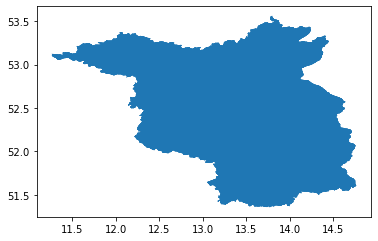

In [ ]:
#playing around
BrandenburgBerlin_df.plot()

In [ ]:
#trying out a Choropleth map

alt.Chart(BrandenburgBerlin_df).mark_geoshape().encode(
    color=alt.Color('totalpopulation 2018', scale=alt.Scale(type="log", domain=[1,1000] )),
    tooltip=['name']
).project (
    ).properties(
    width=1800,
    height=1600
)

NameError: ignored